# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [176]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [177]:
from sklearn.model_selection import cross_val_score 
from sklearn.svm import LinearSVC


min_svm = np.inf
C_svm = 0
for c in np.logspace(-2, 1, 10):
    model_svm = LinearSVC(max_iter=100000, C=c)
    cv_scores = cross_val_score(model_svm, X_train, y_train, cv=5, scoring="roc_auc")
    if np.mean(cv_scores) < min_svm:
        C_svm = c
        min_svm = np.mean(cv_scores)

model_svm = LinearSVC(max_iter=100000, C=C_svm).fit(X_train, y_train)
print('Оптимальный параметр регуляризации: ', C_svm, 'со значением roc-auс: ', min_svm)

Оптимальный параметр регуляризации:  0.21544346900318834 со значением roc-auс:  0.8506311773781802


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

AUC-ROC для метода Linear_SVC:  0.8476493202904729
AUC-ROC для рандомного классификатора:  0.4947862192077116


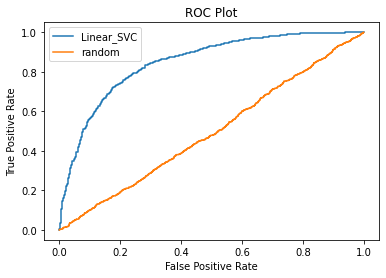

In [178]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from numpy.random import random_sample

roc_result = model_svm.decision_function(X_test)
roc_random_class = 2 * random_sample(len(y_test)) - 1

SVC_roc_auc = roc_auc_score(y_test, roc_result)
random_roc_auc = roc_auc_score(y_test, roc_random_class)

print('AUC-ROC для метода Linear_SVC: ', SVC_roc_auc)
print('AUC-ROC для рандомного классификатора: ', random_roc_auc)

SVC_fpr, SVC_tpr, _ = roc_curve(y_test, roc_result)
random_fpr, random_trp, _ = roc_curve(y_test, roc_random_class)

plt.plot(SVC_fpr, SVC_tpr, label='Linear_SVC')
plt.plot(random_fpr, random_trp, label='random')

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

AUC-PR для метода Linear_SVC:  0.8296916111795498
AUC-PR для рандомного классификатора:  0.5176362894713686


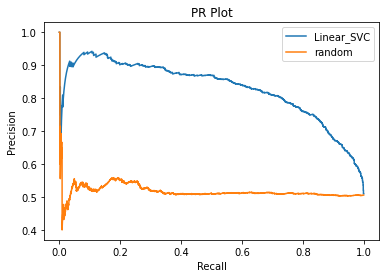

In [179]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from numpy.random import random_sample

pr_result = model_svm.decision_function(X_test)
pr_random_class = 2 * random_sample(len(y_test)) - 1

SVC_pr, SVC_re, _ = precision_recall_curve(y_test, pr_result)
random_pr, random_re, _ = precision_recall_curve(y_test, pr_random_class)

SVC_pr_auc = auc(SVC_re, SVC_pr)
random_pr_auc = auc(random_re, random_pr)

print('AUC-PR для метода Linear_SVC: ', SVC_pr_auc)
print('AUC-PR для рандомного классификатора: ', random_pr_auc)

plt.plot(SVC_re, SVC_pr, label='Linear_SVC')
plt.plot(random_re, random_pr, label='random')

plt.title('PR Plot')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend() 
plt.show()

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [180]:
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LogisticRegression


min_lr = np.inf
C_lr = 0
for c in np.logspace(-2, 1, 10):
    model_lr = LogisticRegression(max_iter=100000, C=c)
    cv_scores = cross_val_score(model_lr, X_train, y_train, cv=5, scoring="roc_auc")
    if np.mean(cv_scores) < min_lr:
        C_lr = c
        min_lr = np.mean(cv_scores)

model_lr = LogisticRegression(max_iter=100000, C=C_lr).fit(X_train, y_train)
print('Оптимальный параметр регуляризации: ', C_lr, 'со значением roc-auс: ', min_lr)

Оптимальный параметр регуляризации:  0.01 со значением roc-auс:  0.8505597474564869


AUC-ROC для метода LogisticRegression:  0.8475870900751252
AUC-ROC для рандомного классификатора:  0.49154891450501864


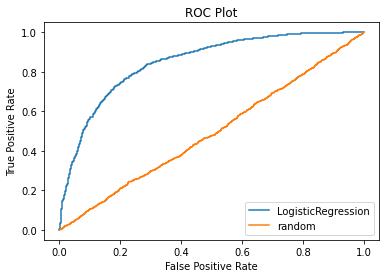

In [181]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from numpy.random import random_sample

roc_result = model_lr.decision_function(X_test)
roc_random_class = 2 * random_sample(len(y_test)) - 1

lr_roc_auc = roc_auc_score(y_test, roc_result)
random_roc_auc = roc_auc_score(y_test, roc_random_class)

print('AUC-ROC для метода LogisticRegression: ', lr_roc_auc)
print('AUC-ROC для рандомного классификатора: ', random_roc_auc)

lr_fpr, lr_tpr, _ = roc_curve(y_test, roc_result)
random_fpr, random_trp, _ = roc_curve(y_test, roc_random_class)

plt.plot(lr_fpr, lr_tpr, label='LogisticRegression')
plt.plot(random_fpr, random_trp, label='random')

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

AUC-PR для метода LogisticRegression:  0.8296759023455974
AUC-PR для рандомного классификатора:  0.5141590198991044


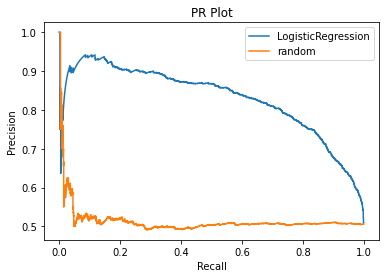

In [182]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from numpy.random import random_sample

pr_result = model_lr.decision_function(X_test)
pr_random_class = 2 * random_sample(len(y_test)) - 1

lr_pr, lr_re, _ = precision_recall_curve(y_test, pr_result)
random_pr, random_re, _ = precision_recall_curve(y_test, pr_random_class)

lr_pr_auc = auc(lr_re, lr_pr)
random_pr_auc = auc(random_re, random_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)
print('AUC-PR для рандомного классификатора: ', random_pr_auc)

plt.plot(lr_re, lr_pr, label='LogisticRegression')
plt.plot(random_re, random_pr, label='random')

plt.title('PR Plot')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend() 
plt.show()

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

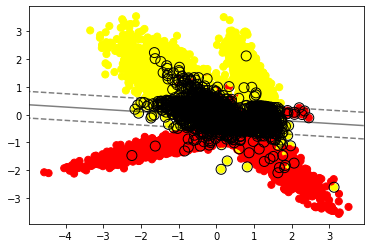

In [183]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

model=SVC(kernel='linear').fit(X, y)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

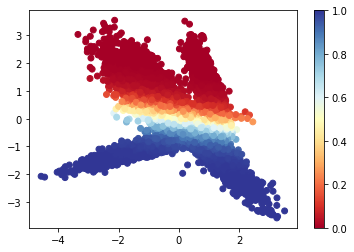

In [184]:
model = LogisticRegression().fit(X, y)
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(X[:, 0], X[:, 1], c=model.predict_proba(X)[:, 0], vmin=0, vmax=1, s=35, cmap=cm)
plt.colorbar(sc)
plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [185]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)])) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.grid()
    plt.show()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

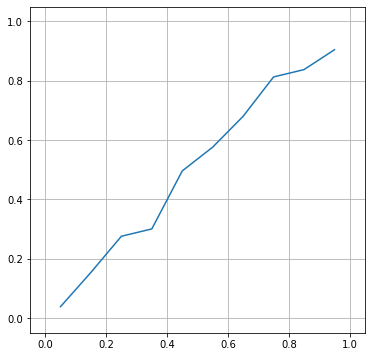

In [186]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

model = LogisticRegression().fit(X_train, y_train)

plot_calibration_curve(y_test, model.predict_proba(X_test)[:, 1])


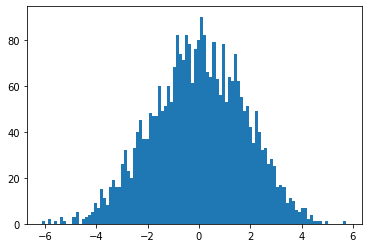

In [187]:
plt.hist(model.decision_function(X_test), bins=100)
plt.show()

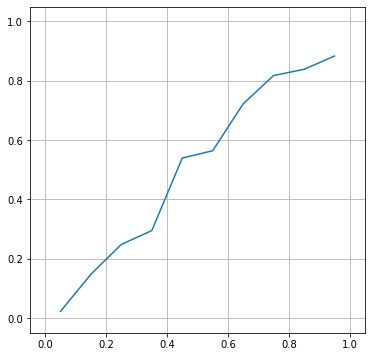

In [188]:
model = SVC(kernel='linear', probability=True).fit(X_train, y_train)

plot_calibration_curve(y_test, model.predict_proba(X_test)[:, 1])

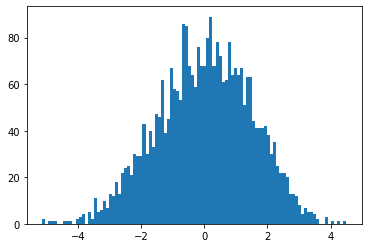

In [189]:
plt.hist(model.decision_function(X_test), bins=100)
plt.show()

Отличие заключается в том, что метод опорных векторов пытается увеличить минимальный отступ, из-за чего скоры на далеких элементах немного меньше, чем у логистической регрессии.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

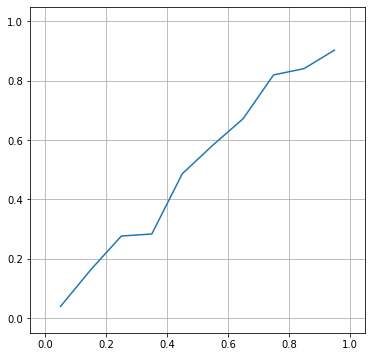

In [190]:
from sklearn.calibration import CalibratedClassifierCV
sigmoid_svc = CalibratedClassifierCV(LinearSVC(max_iter=100000), cv=3, method='sigmoid').fit(X_train, y_train)
plot_calibration_curve(y_test, sigmoid_svc.predict_proba(X_test)[:, 1])

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [191]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [192]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [193]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [194]:
y = df.y
X = df.drop(columns=['duration', 'y'])

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

In [196]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'previous', 'poutcome', 'contact']
numerical_features = ['age', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

ordinal_encoder = OrdinalEncoder().fit(X_train[categorical_features])
standart_scaler = StandardScaler().fit(X_train[numerical_features])

X_train[categorical_features] = ordinal_encoder.transform(X_train[categorical_features])
X_train[numerical_features] = standart_scaler.transform(X_train[numerical_features])

X_test[categorical_features] = ordinal_encoder.transform(X_test[categorical_features])
X_test[numerical_features] = standart_scaler.transform(X_test[numerical_features])

y_train = y_train.map(dict(yes=1, no=0))
y_test = y_test.map(dict(yes=1, no=0))

In [197]:
lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.44183854107783105


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: Выбираем `AUC-PR` так как классы, скорее всего, несбалансированы. 

__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [198]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
y = df.y
X = df.drop(columns=['duration', 'y'])
OHE = pd.get_dummies(X.drop(columns=numerical_features))
X.drop(columns=categorical_features, inplace=True)
X = pd.concat([X, OHE], axis=1)

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [200]:
y_train = y_train.map(dict(yes=1, no=0))
y_test = y_test.map(dict(yes=1, no=0))

In [201]:
standart_scaler = StandardScaler().fit(X_train[numerical_features])
X_train[numerical_features] = standart_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = standart_scaler.transform(X_test[numerical_features])

In [202]:
lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.44926512960681747


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?

In [203]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [204]:
for column in categorical_features:
    stats = df[[column, 'y']].groupby([column]).agg('mean')
    dict_ = stats.T.to_dict('list')
    for key in dict_.keys():
        dict_[key] = dict_[key][0]
    df[column] = df[column].map(dict_)

In [205]:
y = df.y
X = df.drop(columns=['duration', 'y'])

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
standart_scaler = StandardScaler().fit(X_train[numerical_features])
X_train[numerical_features] = standart_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = standart_scaler.transform(X_test[numerical_features])

In [207]:
lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.4410643822163361


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [208]:
#your code here

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [209]:
from numpy.random import rand
df[categorical_features] = df[categorical_features].applymap(lambda x: x - 0.04 * rand() + 0.02)

In [210]:
y = df.y
X = df.drop(columns=['duration', 'y'])

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
standart_scaler = StandardScaler().fit(X_train[numerical_features])
X_train[numerical_features] = standart_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = standart_scaler.transform(X_test[numerical_features])

In [212]:
lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.43704255426325167


__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [213]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [214]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df['y'] = df['y'].map({'yes': 1, 'no': 0})

c = 10
y_mean = df['y'].mean()

for column in categorical_features:
    stats = df[[column, 'y']].groupby([column], as_index=False).agg(['sum', 'count'])
    stats['y'] = (stats['y']['sum'] + c * y_mean) / (stats['y']['count'] + c)
    dict_ = stats.T.to_dict('list')
    for key in dict_.keys():
        dict_[key] = dict_[key][0]
    df[column] = df[column].map(dict_)

In [215]:
y = df.y
X = df.drop(columns=['duration', 'y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

standart_scaler = StandardScaler().fit(X_train[numerical_features])
X_train[numerical_features] = standart_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = standart_scaler.transform(X_test[numerical_features])

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.4409692366171742


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [216]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df['age'].nunique()

78

In [217]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'previous', 'poutcome', 'age', 'contact']
numerical_features = ['campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [218]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

c = 10
y_mean = df['y'].mean()

for column in categorical_features:
    stats = df[[column, 'y']].groupby([column], as_index=False).agg(['sum', 'count'])
    stats['y'] = (stats['y']['sum'] + c * y_mean) / (stats['y']['count'] + c)
    dict_ = stats.T.to_dict('list')
    for key in dict_.keys():
        dict_[key] = dict_[key][0]
    df[column] = df[column].map(dict_)

y = df.y
X = df.drop(columns=['duration', 'y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

standart_scaler = StandardScaler().fit(X_train[numerical_features])
X_train[numerical_features] = standart_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = standart_scaler.transform(X_test[numerical_features])

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.4395711601863246


Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [219]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'previous', 'poutcome', 'age', 'contact']
numerical_features = ['campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'month', 'day_of_week']

d_dict = {'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri': 4}
m_dict = {'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11}

df['month'] = df['month'].map(m_dict)
df['day_of_week'] = df['day_of_week'].map(d_dict)

df['y'] = df['y'].map({'yes': 1, 'no': 0})

c = 10
y_mean = df['y'].mean()

for column in categorical_features:
    stats = df[[column, 'y']].groupby([column], as_index=False).agg(['sum', 'count'])
    stats['y'] = (stats['y']['sum'] + c * y_mean) / (stats['y']['count'] + c)
    dict_ = stats.T.to_dict('list')
    for key in dict_.keys():
        dict_[key] = dict_[key][0]
    df[column] = df[column].map(dict_)

y = df.y
X = df.drop(columns=['duration', 'y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

standart_scaler = StandardScaler().fit(X_train[numerical_features])
X_train[numerical_features] = standart_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = standart_scaler.transform(X_test[numerical_features])

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.43497508273970964


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ OHE проще, надежнее, не допускает утечки целевой переменной, но занимает много места и добавляет вычислительной сложности.

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [220]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'previous', 'poutcome', 'contact']
numerical_features = ['age', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

OHE = pd.get_dummies(X.drop(columns=numerical_features))
X.drop(columns=categorical_features, inplace=True)
X = pd.concat([X, OHE], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [221]:
X.shape[1]

62

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [222]:
lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.4422281769504426


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [223]:
a = lr.coef_[0]
b = []

for k, i in enumerate(a):
    b.append([k, i])

b = sorted(b, key=lambda x: x[1])[:40]
c = []
for i in b:
    c.append(i[0])

In [224]:
X = X.iloc[:, c]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.4355969715203574


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [229]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'previous', 'poutcome', 'contact']
numerical_features = ['age', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

OHE = pd.get_dummies(X.drop(columns=numerical_features))
X.drop(columns=categorical_features, inplace=True)
X = pd.concat([X, OHE], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

standart_scaler = StandardScaler().fit(X_train[numerical_features])
X_train[numerical_features] = standart_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = standart_scaler.transform(X_test[numerical_features])

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

a = lr.coef_[0]
b = []

for k, i in enumerate(a):
    b.append([k, i])

b = sorted(b, key=lambda x: x[1])[-40:]
c = []
for i in b:
    c.append(i[0])

X = X.iloc[:, c]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.4472545293544656
AUC-PR для метода LogisticRegression:  0.409960085528267


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [230]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'previous', 'poutcome', 'contact']
numerical_features = ['age', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

OHE = pd.get_dummies(X.drop(columns=numerical_features))
X.drop(columns=categorical_features, inplace=True)
X = pd.concat([X, OHE], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

standart_scaler = StandardScaler().fit(X_train)
X_train = standart_scaler.transform(X_train)
X_test = standart_scaler.transform(X_test)

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

a = lr.coef_[0]
b = []

for k, i in enumerate(a):
    b.append([k, i])

b = sorted(b, key=lambda x: x[1])[-40:]
c = []
for i in b:
    c.append(i[0])

X = X.iloc[:, c]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.4472596417071614
AUC-PR для метода LogisticRegression:  0.44157158801268714


### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [231]:
from math import sqrt

def foo(column, X, y):
    data_plus = X[y == True]
    data_minus = X[y == False]
    n_plus = data_plus.shape[0]
    n_minus = data_minus.shape[0]

    mean_plus = data_plus[column].mean()
    mean_minus = data_minus[column].mean()

    sd_plus = data_plus[column].std()
    sd_minus = data_minus[column].std()

    return abs(mean_plus - mean_minus) / sqrt((n_plus * sd_plus ** 2 + n_minus * sd_minus ** 2) / (n_plus + n_minus))

In [232]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'previous', 'poutcome', 'contact']
numerical_features = ['age', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

OHE = pd.get_dummies(X.drop(columns=numerical_features))
X.drop(columns=categorical_features, inplace=True)
X = pd.concat([X, OHE], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

standart_scaler = StandardScaler().fit(X_train[numerical_features])
X_train[numerical_features] = standart_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = standart_scaler.transform(X_test[numerical_features])

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

c = list(X.columns)
c = sorted(c, key= lambda x: foo(x, X, y))[-40:]

X = X[c]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)

lr_pr, lr_re, _ = precision_recall_curve(y_test, lr_pred)
lr_pr_auc = auc(lr_re, lr_pr)

print('AUC-PR для метода LogisticRegression: ', lr_pr_auc)

AUC-PR для метода LogisticRegression:  0.4472545293544656
AUC-PR для метода LogisticRegression:  0.44171017322966133


### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from numpy.random import rand
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [2]:
def revenue(y_true, y_pred):
    df = pd.DataFrame(data={'y_true': y_true, 'y_pred': y_pred})
    num_credits = df[(df['y_true']) & (df['y_pred'])].shape[0]
    return num_credits * 10

def cost(y_true, y_pred):
    return y_pred[y_pred].shape[0]

revenue_sc = make_scorer(revenue, greater_is_better=True)
cost_sc = make_scorer(cost, greater_is_better=True)

In [3]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'previous', 'poutcome', 'contact']
numerical_features = ['age', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

OHE = pd.get_dummies(X.drop(columns=numerical_features))
X.drop(columns=categorical_features, inplace=True)
X = pd.concat([X, OHE], axis=1)

X[numerical_features] = StandardScaler().fit_transform(X[numerical_features])

model = LogisticRegression(max_iter=100000)
cv_scores = cross_validate(model, X, y, cv=KFold(shuffle=True), scoring={'revenue': revenue_sc, 'cost': cost_sc})
print('Среднее значение прибыли: ', np.mean([cv_scores['test_revenue'][i] - cv_scores['test_cost'][i] for i in range(5)]))
print('Стандартное отклонение: ', np.std([cv_scores['test_revenue'][i] - cv_scores['test_cost'][i] for i in range(5)]))

Среднее значение прибыли:  1793.6
Стандартное отклонение:  136.23303564113957


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [4]:
def revenue_random(y_true, y_pred):
    df = pd.DataFrame(data={'y_true': y_true, 'y_pred': y_pred})
    num_credits = df[(df['y_true']) & (df['y_pred'])].shape[0]
    return num_credits * rand() * 20

revenue_random_sc = make_scorer(revenue_random, greater_is_better=True)

In [8]:
model_random = LogisticRegression(max_iter=100000)
cv_scores_random = cross_validate(model_random, X, y, cv=KFold(shuffle=True), scoring={'revenue': revenue_random_sc, 'cost': cost_sc})
print('Среднее значение прибыли: ', np.mean([cv_scores_random['test_revenue'][i] - cv_scores['test_cost'][i] for i in range(5)]))
print('Стандартное отклонение: ', np.std([cv_scores_random['test_revenue'][i] - cv_scores['test_cost'][i] for i in range(5)]))

Среднее значение прибыли:  1943.9047590621035
Стандартное отклонение:  1249.7363802429754


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [9]:
def margin(y_true, y_pred):
    df = pd.DataFrame(data={'y_true': y_true, 'y_pred': y_pred})
    num_calls = df[df['y_pred']].shape[0]
    num_credits = df[(df['y_true']) & (df['y_pred'])].shape[0]
    return num_credits * rand() * 20 - num_calls

margin_sc = make_scorer(margin, greater_is_better=True)

In [10]:
lr = LogisticRegression(max_iter=100000)
clf = GridSearchCV(lr, {'C': np.logspace(-2, 2, num=10)}, cv=KFold(shuffle=True), scoring=margin_sc)
clf.fit(X, y)
print('Оптимальный коэффициент регуляризации: ', clf.best_params_['C']) 
print('Значение прибыли при данном коэффициенте: ', clf.best_score_)

Оптимальный коэффициент регуляризации:  0.01
Значение прибыли при данном коэффициенте:  2840.9805117729384


Как видно, удалось получить большее кол-во прибыли.

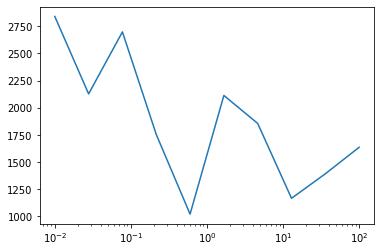

In [11]:
plt.plot(np.logspace(-2, 2, num=10), clf.cv_results_['mean_test_score'])
plt.xscale('log')
plt.show()

In [91]:
for _ in range(10):
    lr = LogisticRegression(max_iter=100000)
    clf = GridSearchCV(lr, {'C': np.logspace(-2, 2, num=10)}, cv=KFold(shuffle=True), scoring=margin_sc)
    clf.fit(X, y)
    print('Оптимальный коэффициент регуляризации: ', clf.best_params_['C']) 

Оптимальный коэффициент регуляризации:  4.6415888336127775
Оптимальный коэффициент регуляризации:  12.915496650148826
Оптимальный коэффициент регуляризации:  0.0774263682681127
Оптимальный коэффициент регуляризации:  100.0
Оптимальный коэффициент регуляризации:  0.027825594022071243
Оптимальный коэффициент регуляризации:  0.21544346900318834
Оптимальный коэффициент регуляризации:  4.6415888336127775
Оптимальный коэффициент регуляризации:  0.5994842503189409
Оптимальный коэффициент регуляризации:  0.21544346900318834
Оптимальный коэффициент регуляризации:  0.027825594022071243


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

То, как мы разобьем данные на фолды, очень сильно влияет на обучение. Поэтому найти какой-то определенный 'лучший' коэффициент не получается.

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ В данной постановке задачи для нас важнее recall, так мы хотим угадать как можно больше клиентов, которые действительно взяли кредит. Если наша модель предсказала положительный класс всего лишь для одного клиента и он действительно взял кредит, то precision будет равен 1, однако, прибыль, которую мы получим в этом случае, далеко не максимальна.



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
model = LogisticRegression(max_iter=100000).fit(X_train, y_train)
test_proba = model.predict_proba(X_test)

margin_log = []

max_margin, max_threshold = 0, 0
for threshold in np.linspace(0, 1, 1001):
    y_predict_prob_class_1 = test_proba[:,1]
    y_predict_class = [True if prob > threshold else False for prob in y_predict_prob_class_1]

    df = pd.DataFrame(data={'y_true': y_test, 'y_pred': y_predict_class})
    num_calls = df[df['y_pred']].shape[0]
    num_credits = df[(df['y_true']) & (df['y_pred'])].shape[0]
    margin = num_credits * rand() * 20 - num_calls
    margin_log.append(margin)
    if margin > max_margin:
        max_margin = margin
        max_threshold = threshold
        precision = precision_recall_fscore_support(y_test, y_predict_class, average='binary')[0]
        recall = precision_recall_fscore_support(y_test, y_predict_class, average='binary')[1]

print('Максимальная прибыль равна: ', max_margin, 'и достигается при пороге: ', max_threshold)

Максимальная прибыль равна:  11011.715063347856 и достигается при пороге:  0.057


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 

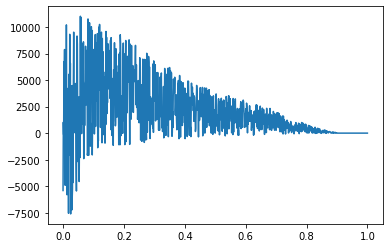

In [33]:
plt.plot(np.linspace(0, 1, 1001), margin_log)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

При threshold = 0 мы относим все элементы выборки к положительному классу, а значит звоним вообще всем и теряем очень много денег на выплату колл-центру. Как только повышаем порог до 0.05-0.15, то отбрасываем большое кол-во элементов, которые скорее всего отрицательные, поэтому в этой области прибыль максимальна. Когда начинаем повышать порог далее, то, хотя и уменьшаем выплаты колл-центру, но не звоним клиентам, которые с достаточно высокой вероятностью принесут прибыль, поэтому прибыль падает до тех пор, пока мы не будем звонить вообще никому. 

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [34]:
print(precision, recall)

0.1799812030075188 0.8254310344827587


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__